<a href="https://colab.research.google.com/github/Nishan-Charlie/SkinCancer/blob/main/isic18_resnet50_LIME.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=4b9c5d733399b0157fd3a15aa732afef510842c2852e44d06b621a20e404470f
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
import os
import random

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, models, transforms
from torchvision.models import ResNet50_Weights, resnet50
from PIL import Image


from lime import lime_image
from skimage.segmentation import mark_boundaries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
base = "/content/drive/MyDrive/Research/Skin Cancer"

In [ ]:
isic_csv = "/content/drive/MyDrive/Research/Skin Cancer/ISIC2018_Task3_Training_LesionGroupings.csv"

In [ ]:
df = pd.read_csv(isic_csv)
df.head()

,image,lesion_id,diagnosis_confirm_type
0,ISIC_0024306,HAM_0000550,serial imaging showing no change
1,ISIC_0024307,HAM_0003577,serial imaging showing no change
2,ISIC_0024308,HAM_0001477,serial imaging showing no change
3,ISIC_0024309,HAM_0000484,serial imaging showing no change
4,ISIC_0024310,HAM_0003350,histopathology


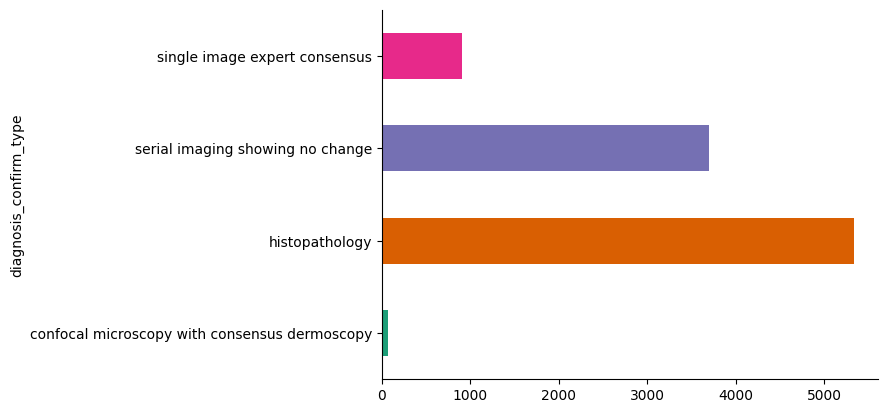

In [ ]:


df.groupby('diagnosis_confirm_type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
df['class'] = df['lesion_id'].str.split('_').str[0]

# Display the updated DataFrame
df.head()

,image,lesion_id,diagnosis_confirm_type,class
0,ISIC_0024306,HAM_0000550,serial imaging showing no change,HAM
1,ISIC_0024307,HAM_0003577,serial imaging showing no change,HAM
2,ISIC_0024308,HAM_0001477,serial imaging showing no change,HAM
3,ISIC_0024309,HAM_0000484,serial imaging showing no change,HAM
4,ISIC_0024310,HAM_0003350,histopathology,HAM


In [ ]:
ground_truth = "/content/drive/MyDrive/Research/Skin Cancer/ISIC images/ISIC2018_Task3_Training_GroundTruth.csv"

In [ ]:
ground_truth_df = pd.read_csv(ground_truth)

In [ ]:
ground_truth_df.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
ground_truth_df['class'] = ground_truth_df.iloc[:, 1:].idxmax(axis=1)

# Display the updated DataFrame
ground_truth_df.head()
image_folder = "/content/drive/MyDrive/Research/Skin Cancer/ISIC images/ISIC2018_Task3_Training_Input"

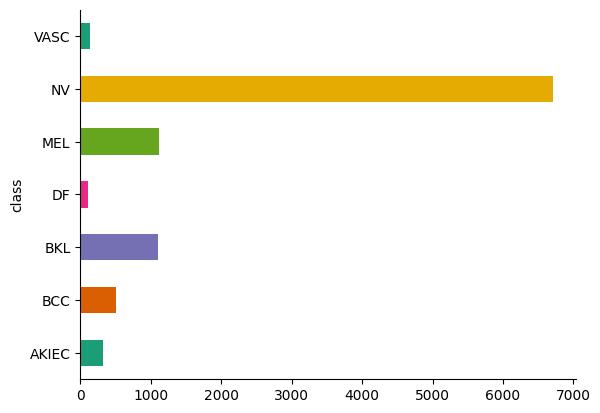

In [ ]:
ground_truth_df.groupby('class').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
class_counts = ground_truth_df['class'].value_counts()

print(class_counts)

class
NV       6705
MEL      1113
BKL      1099
BCC       514
AKIEC     327
VASC      142
DF        115
Name: count, dtype: int64


In [ ]:
# Filter NV class and randomly sample 1200 images
nv_class = ground_truth_df[ground_truth_df['class'] == 'NV'].sample(n=1200, random_state=42)

# Get all other classes (DF, BCC, AKIEC)
other_classes = ground_truth_df[ground_truth_df['class'].isin(['DF', 'BCC', 'AKIEC', 'VASC','MEL','BKL'])]

# Combine NV samples with other classes
balanced_df = pd.concat([nv_class, other_classes], axis=0).reset_index(drop=True)

# Shuffle the dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

print("Dataset distribution after balancing:")
print(balanced_df['class'].value_counts())

Dataset distribution after balancing:
class
NV       1200
MEL      1113
BKL      1099
BCC       514
AKIEC     327
VASC      142
DF        115
Name: count, dtype: int64


In [ ]:

# Define Dataset
class SkinCancerDataset(Dataset):
    def __init__(self, dataframe, image_folder, class_augmentations, default_transform=None):
        self.dataframe = dataframe
        self.image_folder = image_folder
        self.class_augmentations = class_augmentations
        self.default_transform = default_transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Get image name and class
        image_name = self.dataframe.iloc[idx]['image'] + ".jpg"  # Assuming images are in .jpg format
        image_path = os.path.join(self.image_folder, image_name)
        label = self.dataframe.iloc[idx]['class']

        # Convert class names to numerical labels
        class_to_idx = {'NV': 0, 'DF': 1, 'BCC': 2, 'AKIEC': 3, 'VASC':4,'MEL':5,'BKL':6}
        label = class_to_idx[label]

        # Load image
        image = Image.open(image_path).convert("RGB")

        if label in self.class_augmentations:
            transform = self.class_augmentations[label]
        else:
            transform = self.default_transform  # Apply default transformation if not specified

        if transform:
            image = transform(image)

        return image, label


In [ ]:
class_augmentations = {
    2: transforms.Compose([  # BCC class
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.3, contrast=0.3),
        transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    3: transforms.Compose([  # AKIEC class
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),
        transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    4: transforms.Compose([  # VASC class
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(25),
        transforms.ColorJitter(saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    1: transforms.Compose([  # DF class
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.RandomCrop(224, padding=20),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

default_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare Dataset
image_folder = "/content/drive/MyDrive/Research/Skin Cancer/ISIC images/ISIC2018_Task3_Training_Input"
dataset = SkinCancerDataset(dataframe=balanced_df,
                            image_folder=image_folder,
                            class_augmentations=class_augmentations,
                            default_transform=default_transform
                            )

# Split Dataset into Training and Validation Sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Prepare DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

In [ ]:
# Load Pre-trained ResNet-50
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

# Modify the final fully connected layer
num_classes = balanced_df['class'].nunique()
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Send model to device
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop with validation
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Training Loop
    for images, labels in train_loader:
        # Move data to device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total * 100

    # Validation Loop
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            # Move data to device
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_acc = val_correct / val_total * 100

    print(
        f"Epoch {epoch + 1}/{num_epochs}, "
        f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.2f}%, "
        f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%"
    )

# Save the model
torch.save(model.state_dict(), "resnet50_skin_cancer.pth")
print("Model training completed and saved!")


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1/30, Train Loss: 0.9363, Train Accuracy: 62.70%, Val Loss: 0.8581, Val Accuracy: 67.18%
Epoch 2/30, Train Loss: 0.7652, Train Accuracy: 69.01%, Val Loss: 0.7054, Val Accuracy: 70.51%
Epoch 3/30, Train Loss: 0.6731, Train Accuracy: 72.09%, Val Loss: 0.6763, Val Accuracy: 73.17%
Epoch 4/30, Train Loss: 0.6453, Train Accuracy: 73.44%, Val Loss: 0.8619, Val Accuracy: 66.74%
Epoch 5/30, Train Loss: 0.6275, Train Accuracy: 74.25%, Val Loss: 0.6218, Val Accuracy: 69.84%
Epoch 6/30, Train Loss: 0.5773, Train Accuracy: 76.03%, Val Loss: 0.6256, Val Accuracy: 76.72%
Epoch 7/30, Train Loss: 0.5453, Train Accuracy: 77.68%, Val Loss: 0.6259, Val Accuracy: 72.28%
Epoch 8/30, Train Loss: 0.5215, Train Accuracy: 78.89%, Val Loss: 0.8984, Val Accuracy: 68.07%
Epoch 9/30, Train Loss: 0.4836, Train Accuracy: 80.68%, Val Loss: 0.7507, Val Accuracy: 71.84%
Epoch 10/30, Train Loss: 0.4691, Train Accuracy: 81.74%, Val Loss: 0.6869, Val Accuracy: 70.95%
Epoch 11/30, Train Loss: 0.4371, Train Accuracy: 

Model metrices

In [ ]:
import sklearn
from sklearn import metrics
from sklearn.metrics import confusion_matrix,recall_score



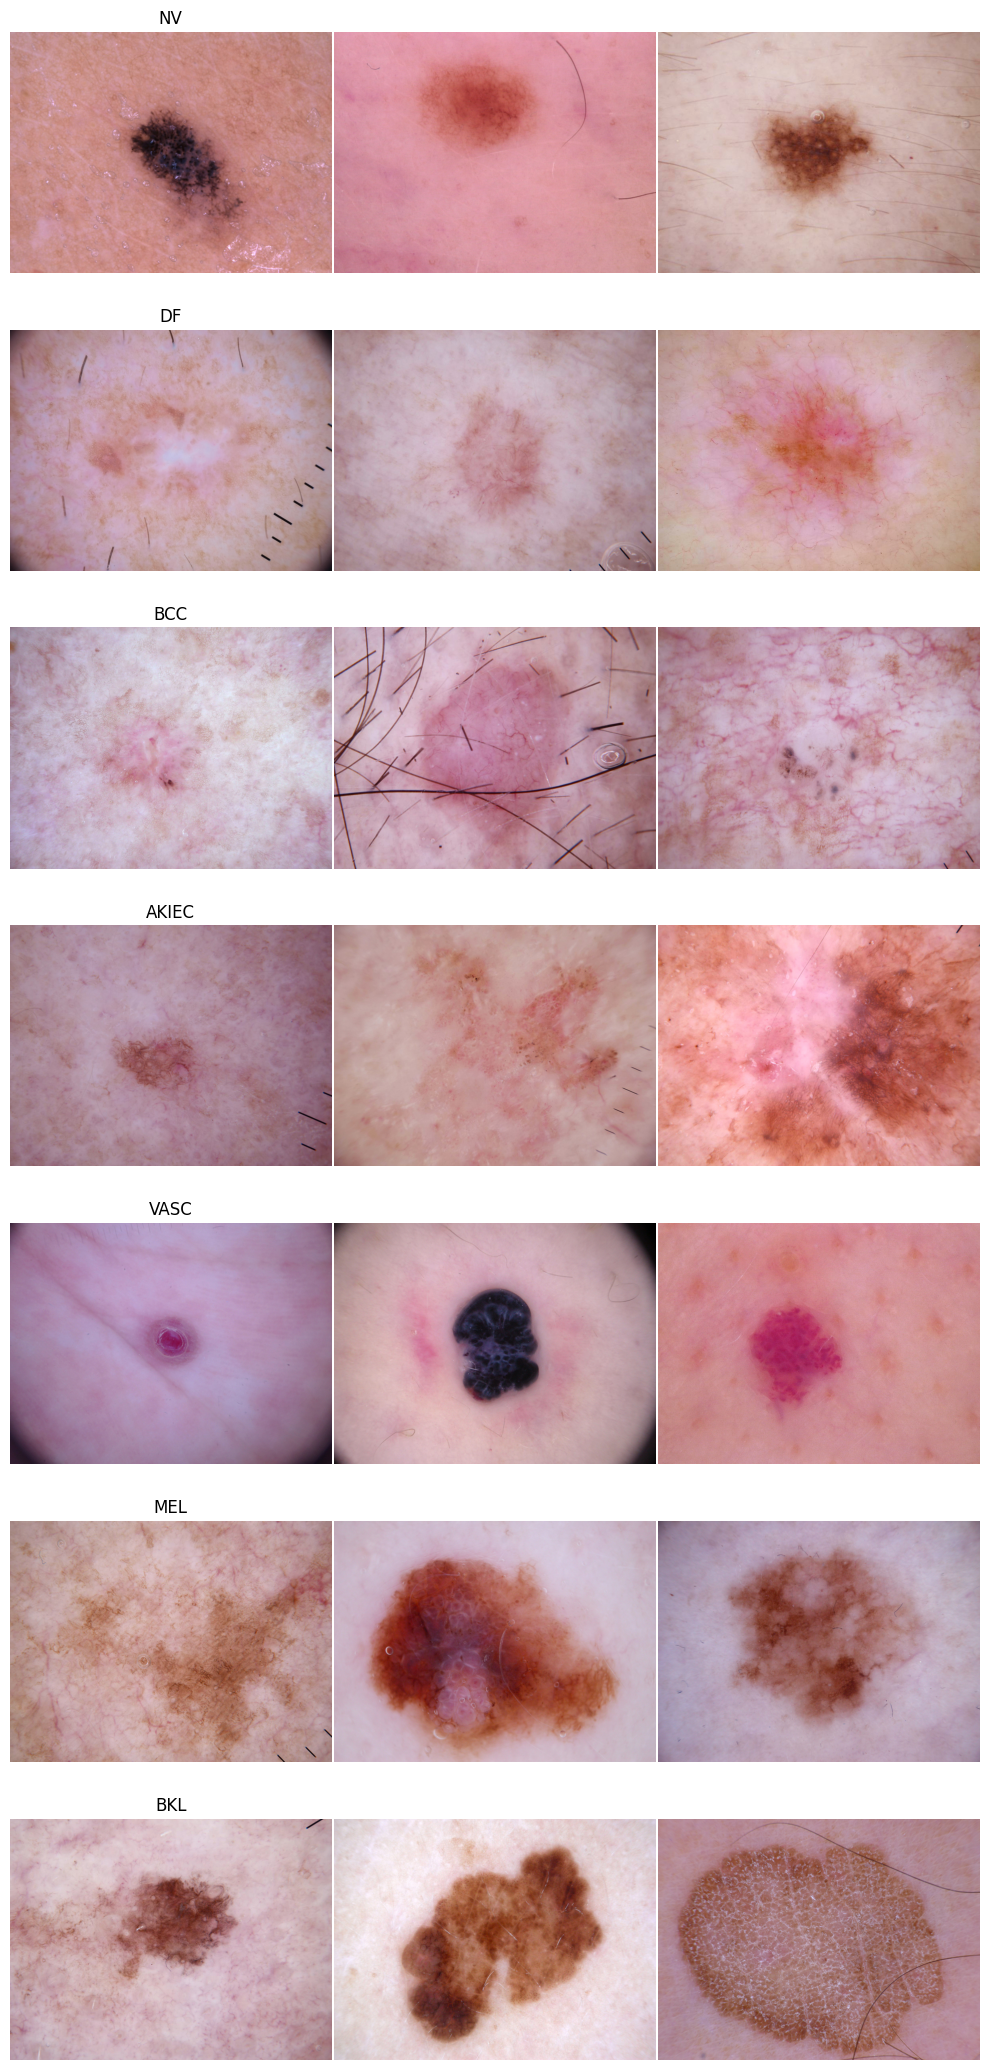

In [ ]:
# Define the image directory
image_folder = "/content/drive/MyDrive/Research/Skin Cancer/ISIC images/ISIC2018_Task3_Training_Input"

# Define classes and the dataframe
classes = ['NV', 'DF', 'BCC', 'AKIEC', 'VASC', 'MEL', 'BKL']
num_samples = 3  # Number of images to sample per class

# Dictionary to store selected images
selected_images = {}

# Iterate through each class and randomly select images
for cls in classes:
    # Filter dataframe for the current class
    class_images = balanced_df[balanced_df['class'] == cls]

    # Randomly sample images
    sampled_images = class_images.sample(n=num_samples, random_state=42)

    # Load the images and store them
    selected_images[cls] = []
    for _, row in sampled_images.iterrows():
        image_name = row['image'] + ".jpg"
        image_path = os.path.join(image_folder, image_name)

        if os.path.exists(image_path):
            image = Image.open(image_path).convert("RGB")
            selected_images[cls].append(image)
        else:
            print(f"Image not found: {image_path}")

# Plot the images in a grid
fig, axs = plt.subplots(len(classes), num_samples, figsize=(10, len(classes) * 3))
plt.subplots_adjust(hspace=0.5)

for row_idx, cls in enumerate(classes):
    for col_idx in range(num_samples):
        ax = axs[row_idx, col_idx]
        ax.axis('off')

        # Check if there are enough images for the class
        if col_idx < len(selected_images[cls]):
            ax.imshow(selected_images[cls][col_idx])
            ax.set_title(cls if col_idx == 0 else "")
        else:
            ax.set_visible(False)

plt.tight_layout()
plt.show()


In [ ]:
def predict_for_lime(images):

    model.eval()  # Set model to evaluation mode
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to match model input size
        transforms.ToTensor(),         # Convert to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
    ])

    # Preprocess the images
    processed_images = torch.stack([preprocess(Image.fromarray(image)) for image in images])

    # Move to GPU if available
    processed_images = processed_images.to(device)

    # Get predictions from the model
    with torch.no_grad():
        logits = model(processed_images)
        probs = torch.nn.functional.softmax(logits, dim=1)
    return probs.cpu().numpy()  # Return predictions as NumPy array



In [ ]:
# Apply LIME to each sampled image
explainer = lime_image.LimeImageExplainer()

for cls, images in selected_images.items():
    print(f"Processing class: {cls}")
    for idx, image in enumerate(images):
        # Convert PIL image to NumPy array
        image_np = np.array(image)

        # Explain the prediction using LIME
        explanation = explainer.explain_instance(
            image_np,            # Input image as NumPy array
            predict_for_lime,    # Prediction function
            top_labels=3,        # Number of top labels to explain
            hide_color=0,        # Background color for superpixels
            num_samples=1000     # Number of samples for perturbation
        )

        # Get explanation visualization
        temp, mask = explanation.get_image_and_mask(
            explanation.top_labels[0],  # Get the top predicted class
            positive_only=False,
            num_features=10,           # Number of superpixels to highlight
            hide_rest=False
        )

        # Plot the explanation
        plt.figure(figsize=(8, 8))
        plt.imshow(mark_boundaries(temp, mask))
        plt.title(f"LIME Explanation for {cls}, Image {idx+1}")
        plt.axis('off')
        plt.show()

#SHAP